In [2]:
def drop_trials(epochs, chs=[0], do_peak=0, do_mean=0, do_slope=0, T1=0, T2=0, iter_inf=False):
    # Create a copy of epochs
    
    from scipy.stats import iqr
    from scipy.stats import median_abs_deviation as mad

    new_epochs = epochs.copy()
    # Create a list to keep track of trial status (1 for good trials, 0 for rejected trials)
    list_trials = np.ones(len(new_epochs))

    for j in chs:
        # Initialize variables for peak rejection
        peak_rejection = 0
        mean_rejection = 0
        slope_rejection = 0
        ite_peak = 0
        ite_mean = 0
        ite_slope = 0
        stop_peak = 0
        stop_mean = 0
        stop_slope = 0
        ite_loop = 0

        # Main loop for outlier detection and rejection
        while ite_mean > -1:
            ite_loop += 1

            if do_peak == 1:
                if ite_peak == 0:
                    # Calculate time indices based on T1 and T2 values
                    time1 = np.where(new_epochs.times < T1)[0][-1]
                    time2 = np.where(new_epochs.times < T2)[0][-1]

                    # Calculate peak-to-peak values for each trial and channel
                    peak_to_peak = np.array([max(new_epochs._data[i][j][time1:time2]) - min(new_epochs._data[i][j][time1:time2]) for i in range(len(new_epochs._data))], dtype=np.dtype(float))

                idx = []
                for i in range(len(new_epochs._data)):
                    value_prtp = peak_to_peak[i]

                    # Check if the value exceeds the upper threshold for peak rejection
                    
                    Q1, Q3 = np.nanquantile(peak_to_peak,[.25,.75])
                    outlier_up_peak = Q3 + (2 * iqr(peak_to_peak, nan_policy='omit'))
                    if value_prtp  > outlier_up_peak : #append good trials to keep them 
                        idx.append(i)

                if len(idx) == 0:
                    # No more outliers found, stop peak outlier detection
                    stop_peak = 1
                else:
                    ite_peak += 1
                    peak_to_peak[idx] = None
                    list_trials[idx] = 0
                    peak_rejection += len(idx)

            if do_slope == 1:
                if ite_slope == 0:
                    # Calculate time indices based on T1 and T2 values
                    time1 = np.where(new_epochs.times < T1)[0][-1]
                    time2 = np.where(new_epochs.times < T2)[0][-1]

                    x = new_epochs.times[time1:time2]
                    # Calculate slopes for each trial and channel
                    slopes_trials = np.array([np.polyfit(x, new_epochs._data[i, j, time1:time2], 1)[0] for i in range(len(new_epochs._data))], dtype=np.dtype(float))

                idx = []
                for i in range(len(new_epochs._data)):
                    value_prtp = slopes_trials[i]

                    # Check if the value exceeds the upper and lower thresholds for slope rejection
                    
                    Q1, Q3 = np.nanquantile(slopes_trials,[.25,.75])
                    outlier_up_mean = Q1 +(2 * iqr(slopes_trials, nan_policy='omit'))
                    outlier_down_mean = Q3 - (2 * iqr(slopes_trials, nan_policy='omit'))
                    if value_prtp > outlier_up_mean :
                        idx.append(i)
                    elif value_prtp < outlier_down_mean :
                        idx.append(i)

                if len(idx) == 0:
                    # No more outliers found, stop slope outlier detection
                    stop_slope = 1
                else:
                    ite_slope += 1
                    slopes_trials[idx] = None
                    list_trials[idx] = 0
                    slope_rejection += len(idx)

            if do_mean == 1:
                if ite_mean == 0:
                    # Calculate time indices based on T1 and T2 values
                    time1 = np.where(new_epochs.times < T1)[0][-1]
                    time2 = np.where(new_epochs.times < T2)[0][-1]
                    # Calculate mean values for each trial and channel
                    mean_trials = np.array([np.mean(new_epochs._data[i][j][time1:time2]) for i in range(len(new_epochs._data))], dtype=np.dtype(float))

                idx = []
                for i in range(len(new_epochs._data)):
                    value_prtp = mean_trials[i]

                    # Check if the value exceeds the upper and lower thresholds for mean rejection
                    Q1, Q3 = np.nanquantile(mean_trials,[.25,.75])
                    outlier_up_mean = Q3 + (2 * iqr(mean_trials, nan_policy='omit'))
                    outlier_down_mean = Q1 - (2 * iqr(mean_trials, nan_policy='omit'))
                    if value_prtp > outlier_up_mean:
                        idx.append(i)
                    elif value_prtp < outlier_down_mean:
                        idx.append(i)

                if len(idx) == 0:
                    # No more outliers found, stop mean outlier detection
                    stop_mean = 1
                else:
                    ite_mean += 1
                    mean_trials[idx] = None
                    list_trials[idx] = 0
                    mean_rejection += len(idx)

            # Check if any outlier detection is disabled
            if do_peak == 0 | iter_inf == False :
                stop_peak = 1
            if do_mean == 0 | iter_inf == False:
                stop_mean = 1
            if do_slope == 0 | iter_inf == False:
                stop_slope = 1

            # Check if all outlier detection has stopped
            if stop_mean == 1 and stop_peak == 1 and stop_slope == 1:
                # No more outlier detection, stop the loop
                break

    # Drop the trials marked for removal and return the modified epochs object
    new_epochs.drop(np.where(list_trials == 0)[0])
    return new_epochs, peak_rejection, mean_rejection, slope_rejection, list_trials, ite_loop


In [8]:
# Import the required libraries
import os, mne, csv
import numpy as np
import pandas as pd 
from mne.channels import make_standard_montage
from glob import glob
from scipy import stats
from scipy.stats import iqr, median_abs_deviation as mad
from mne.time_frequency import tfr_morlet

#set directory pathway
os.chdir('C:/Users/mfbpe/Desktop/DATA/2023_Social_Influence/derivatives')


data_files = glob('*_raw.fif')


In [4]:
%%capture
# Define empty lists to store participant information and drop statistics
participant = {}
drop_stats = []

# Loop over the data files

for part_i,part in enumerate(data_files):
    try:

        # Read the raw EEG data file
        n_part = part.split("sub-")[1].split("_")[0]
        raw = mne.io.read_raw_fif(part, preload=True)

        if part_i == 0 :
            sphere = mne.make_sphere_model('auto', 'auto', raw.info)
            src = mne.setup_volume_source_space(sphere=sphere)
            forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)
        raw.set_eeg_reference('REST', forward=forward)
        event_dict_selection = {'selection/forced/authority/yes':19,'selection/forced/authority/no':20,'selection/forced/group/yes':21,'selection/forced/group/no':22,'selection/forced/indiv/yes':23,'selection/forced/indiv/no':24,
                'selection/free/authority/yes':25,'selection/free/authority/no':26,'selection/free/group/yes':27,'selection/free/group/no':28,'selection/free/indiv/yes':29,'selection/free/indiv/no':30}

        if n_part == '170': # no selection indiv yes free
            event_dict_selection = {'selection/forced/authority/yes':19,'selection/forced/authority/no':20,'selection/forced/group/yes':21,'selection/forced/group/no':22,'selection/forced/indiv/yes':23,'selection/forced/indiv/no':24,
                'selection/free/authority/yes':25,'selection/free/authority/no':26,'selection/free/group/yes':27,'selection/free/group/no':28,'selection/free/indiv/no':30}
        if n_part == '936': # no selection indiv no free
            event_dict_selection = {'selection/forced/authority/yes':19,'selection/forced/authority/no':20,'selection/forced/group/yes':21,'selection/forced/group/no':22,'selection/forced/indiv/yes':23,'selection/forced/indiv/no':24,
                    'selection/free/authority/yes':25,'selection/free/authority/no':26,'selection/free/group/yes':27,'selection/free/group/no':28,'selection/free/indiv/yes':29}
        events,event_dict = mne.events_from_annotations(raw, event_dict_selection)

        # Create epochs from the raw data based on the defined events and event dictionary
        epochs = mne.Epochs(raw, events, baseline=None, event_id=event_dict_selection,
                            picks=['Fz', 'Cz', 'FC1', 'FC2'], tmin=-2.5, tmax=2.5,
                            preload=True, detrend=None, event_repeated='drop', on_missing='ignore')

        # Combine channels of the epochs
        event_id = epochs.event_id
        epochs = mne.channels.combine_channels(epochs, dict(Avg=list(range(len(epochs.info['chs'])))))
        epochs.event_id = event_id

        # Apply baseline correction to the epochs data
        epochs.apply_baseline((1,1.5))


        # # Drop trials based on criteria (mean, peak, slope) and obtain drop statistics
        epochs, _, _, _, list_ti, _ = drop_trials(epochs, do_mean=1, do_peak=1, do_slope=0,
                                                    T1=-1.5, T2=1.5, chs=list(range(len(epochs.info['chs']))))

        freqs = np.logspace(np.log10(2), np.log10(30), num=80)  # Frequency range for analysis
        n_cycles = np.logspace(np.log10(4), np.log10(14), 80)  # Number of cycles per frequency
                
        power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, average=False,
                        return_itc=False, n_jobs=-1)
        power.save(part.split('raw.fif')[0] + 'tfr.h5', overwrite=True)


        drop_stats.append(epochs.drop_log_stats())  # Store drop statistics
    except :
        participant[part] = [part_i, "Trouble"]


In [ ]:
%%capture
# Import the required libraries
import os, mne, csv
import numpy as np
from glob import glob

#set directory pathway
os.chdir('C:/Users/mfbpe/Desktop/DATA/2023_Social_Influence/derivatives/')
data_files = glob('*_tfr.h5')
all_evokeds = []  # Dictionary to store evoked data for all conditions
drop_stats = []  # List to store drop statistics
participant_n = []
# Iterate over data files
for part_i,part in enumerate(data_files):
# for part in range(30):
    power = mne.time_frequency.read_tfrs(part)
    all_evokeds.append(power.crop(-1.6,1.6))
    n_part = part.split("sub-")[1].split("_")[0]
    if int(n_part)<500:
        participant_n.append("Belgium")
    elif int(n_part)<800:
        participant_n.append("Cambodia")
    else :
        participant_n.append("Rwanda")
    if int(n_part) in [179, 740, 945, 950, 956]:
        participant_n[-1] = "Bad_part"
        
    # drop_stats.append((power.drop_log.count(('USER',))/len(power.drop_log))*100)


In [2]:
for power in all_evokeds: 

    chs=0
    imin_baseline = np.where(power.times<=.5)[0][-1]
    imax_baseline = np.where(power.times<=1.5)[0][-1]
    imin = np.where(power.times<=-1.5)[0][-1]
    imax = np.where(power.times<=1.5)[0][-1]
    for n_trial in range(len(power)):
        data= power._data[n_trial,...]
        mean = np.mean(data[...,imin:imax],axis=-1,keepdims=True)
        std = np.std(data[...,imin:imax],axis=-1,keepdims=True)
        data-=mean
        data /= std


    power_avg = power.average()
    mean_avg = np.mean(power_avg._data[...,imin_baseline:imax_baseline],axis=-1,keepdims=True)
    std_avg = np.std(power_avg._data[...,imin_baseline:imax_baseline],axis=-1,keepdims=True)
    
    for n_trial in range(len(power)):
        data= power._data[n_trial,...]
        data-=mean_avg
        data /= std_avg

In [ ]:
%%capture
# Compute the grand average of time-frequency data across conditions and participants
gr_evok = mne.grand_average([part.average()
                            for i,part in enumerate(all_evokeds)],
                        interpolate_bads=True)

In [6]:
%%capture

p01, p005, p001 = [1.65, 1.96, 2.58]
# Calculate the upper and lower significance thresholds
gr_evok_copy=gr_evok.copy().crop(-1.5, 1.5)
signif_up = np.mean(gr_evok_copy.data) + (p005 * np.std(gr_evok_copy.data))
signif_down = np.mean(gr_evok_copy.data) - (p005 * np.std(gr_evok_copy.data))

gr_evok_copy=gr_evok.copy()

# Replace values below the lower outlier threshold with -10
gr_evok_copy.data[gr_evok_copy.data < signif_down] = 100

# Replace values above the upper outlier threshold with 10
gr_evok_copy.data[gr_evok_copy.data > signif_up] = 100

# Create a boolean mask where the values are equal to 10
mask = gr_evok_copy.data ==False
# mask[gr_evok_copy.data<.5]= True
mask[gr_evok_copy.data==100]= True
# mask[0,np.where(gr_evok.freqs<=4)[0][-1]:np.where(gr_evok.freqs<=8)[0][-1],np.where(gr_evok.times<=-.8)[0][-1]:np.where(gr_evok.times<=.2)[0][-1]]= True
# mask[0,:,]= True
mask[0,np.where(gr_evok.freqs<=7)[0][-1]:,:]= False
# mask[0,:,np.where(gr_evok.times<=0.2)[0][-1]:]= False


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
# ValueError: 'RgfdsBu' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

gr_evok.plot(vlim=(-4,7), mask=np.squeeze(mask), cmap="RdBu_r" ,mask_cmap='jet', mask_alpha=.8, mask_style="contour")
# gr_evok.plot(vlim=(-4,7), cmap="jet" )

plt.xlabel('Time (in s)', fontsize = 30)
plt.ylabel('Frequency (in Hz)', fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


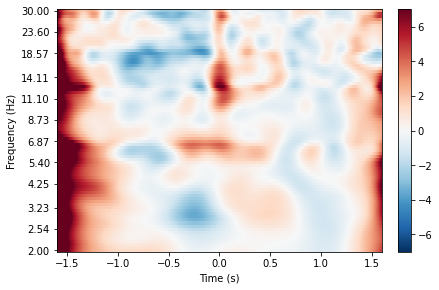

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


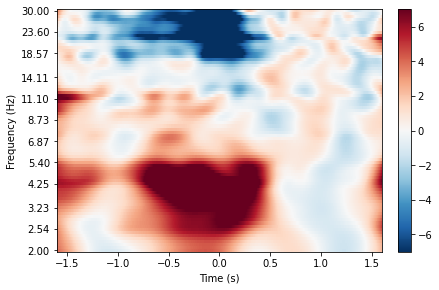

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


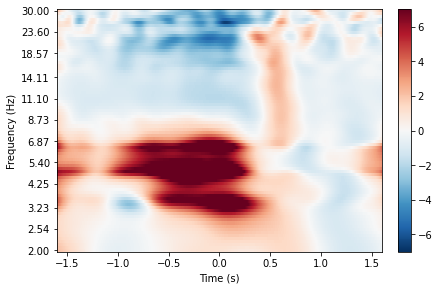

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


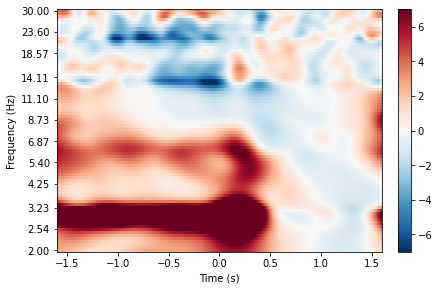

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


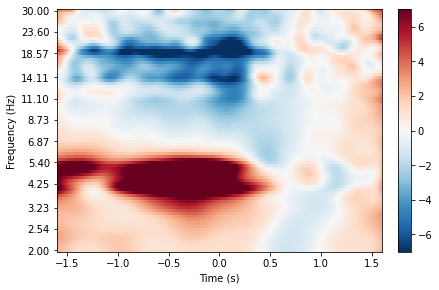

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


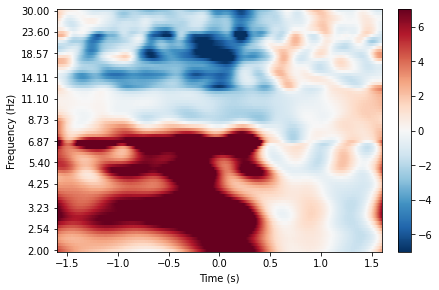

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


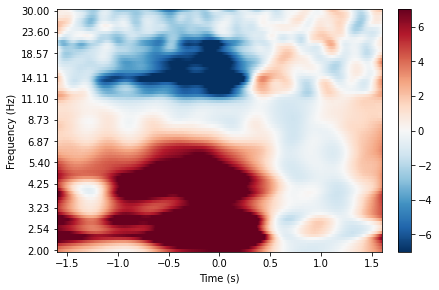

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


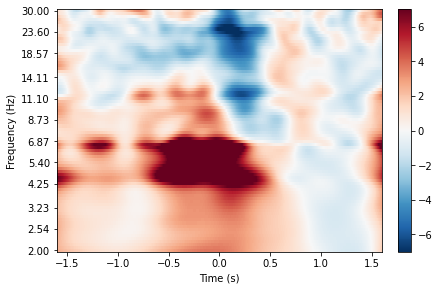

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


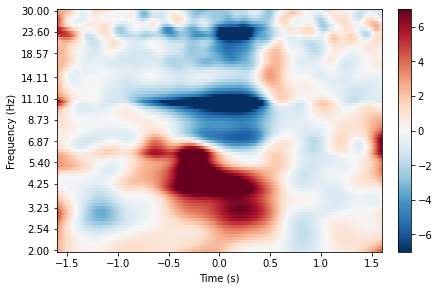

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


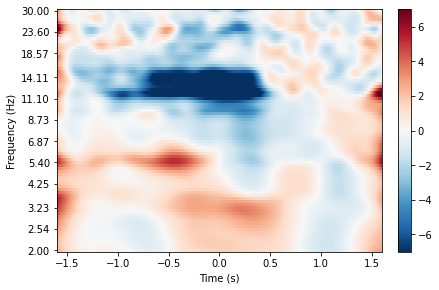

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


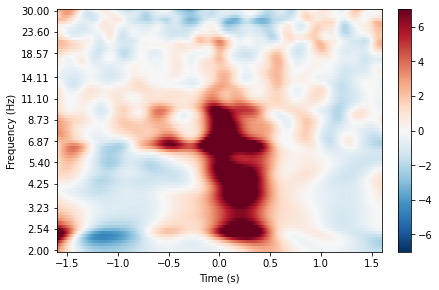

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


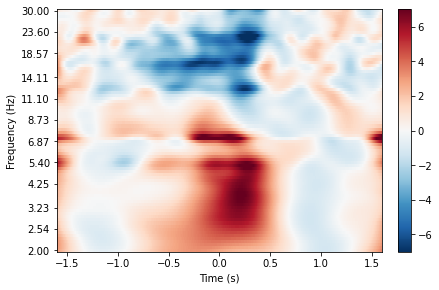

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


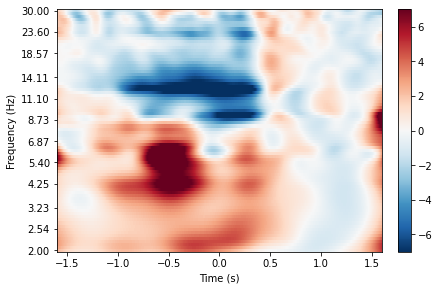

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


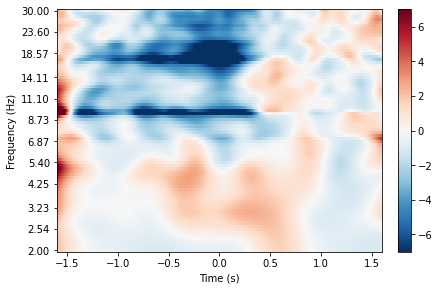

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


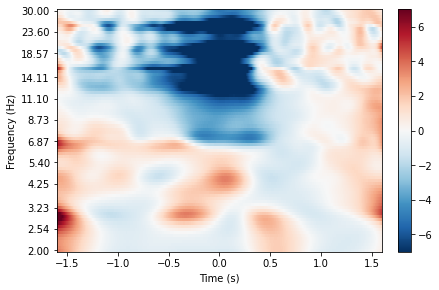

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


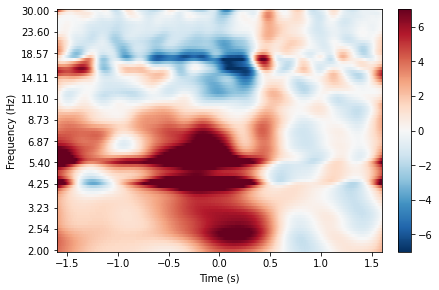

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


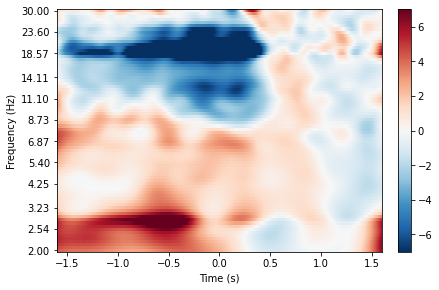

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


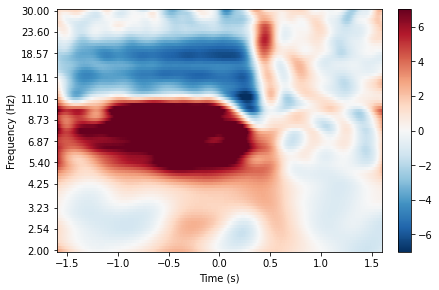

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


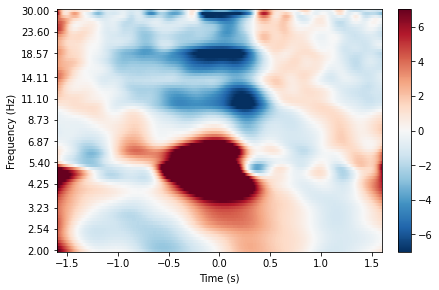

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


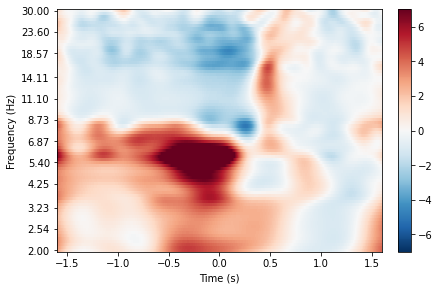

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


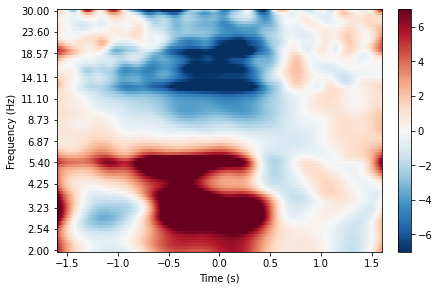

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


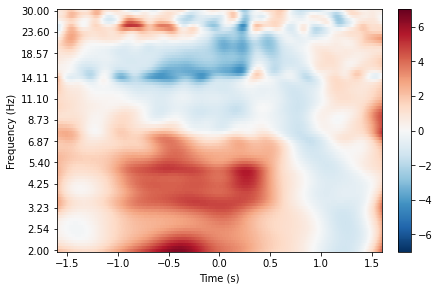

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


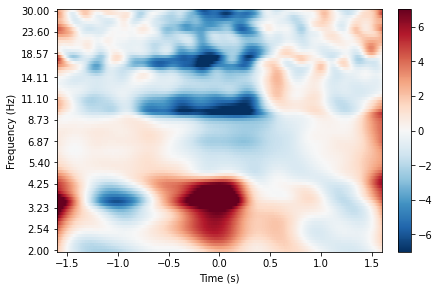

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


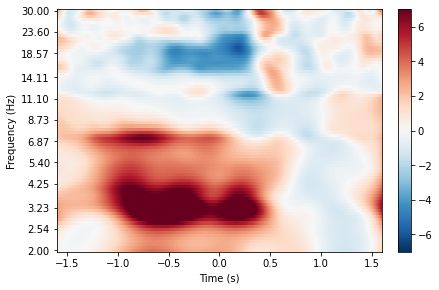

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


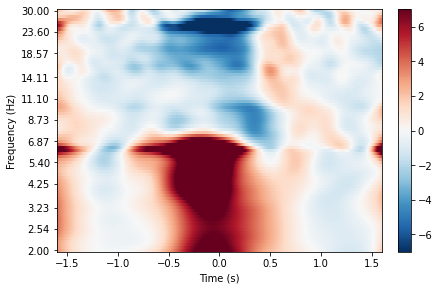

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


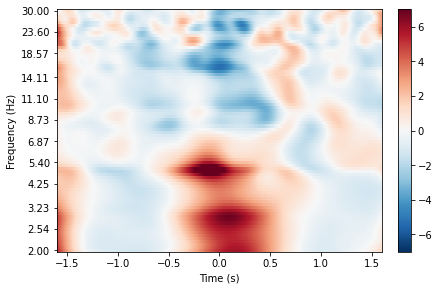

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


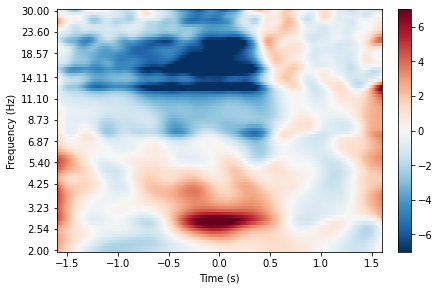

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


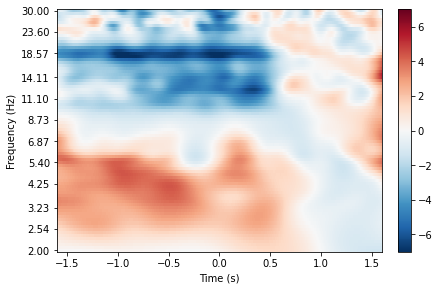

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


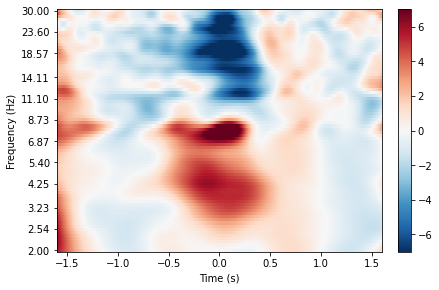

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


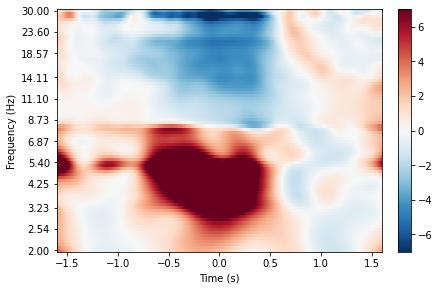

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


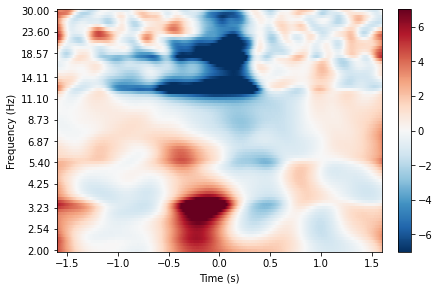

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


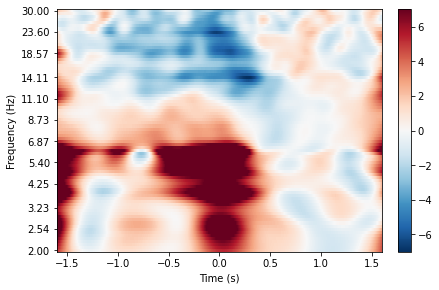

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


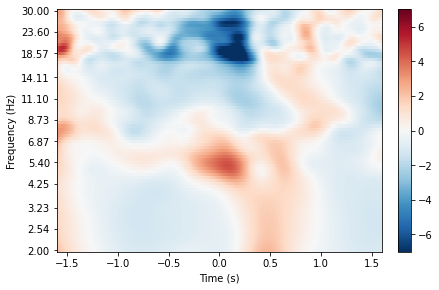

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


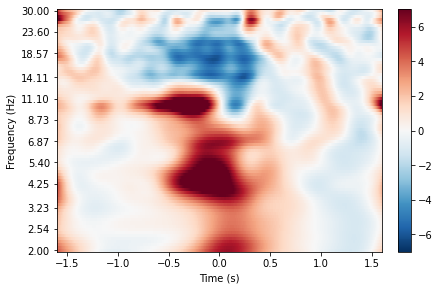

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


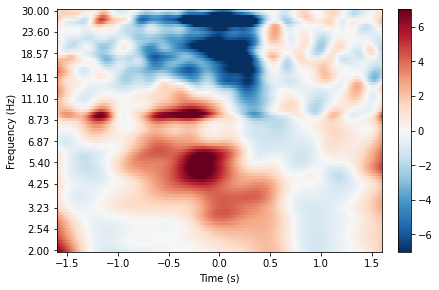

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


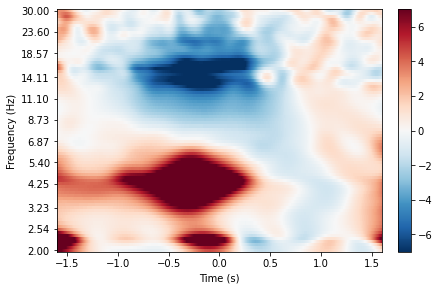

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


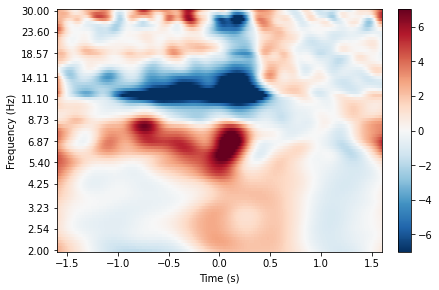

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


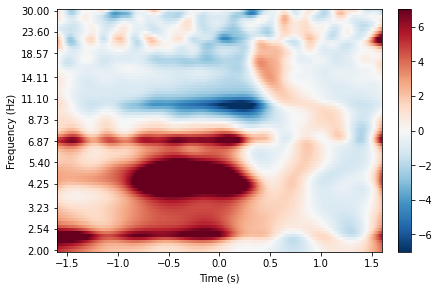

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


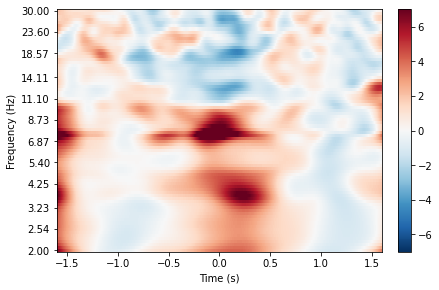

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


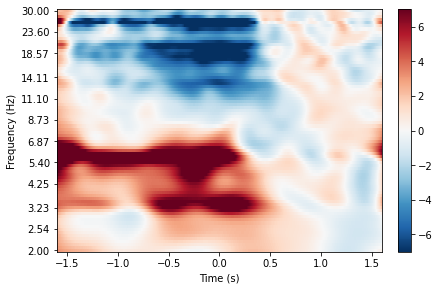

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


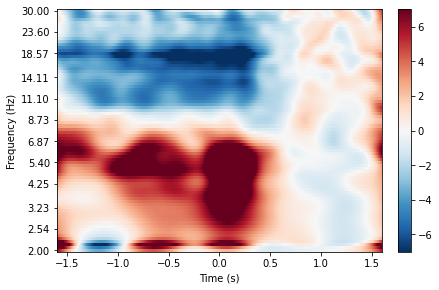

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


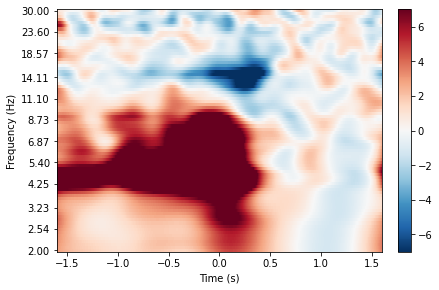

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


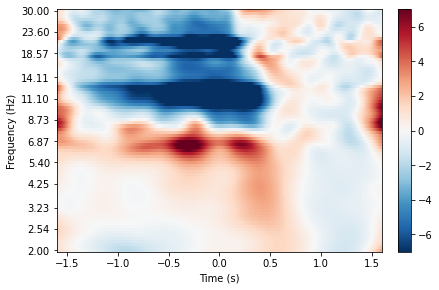

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


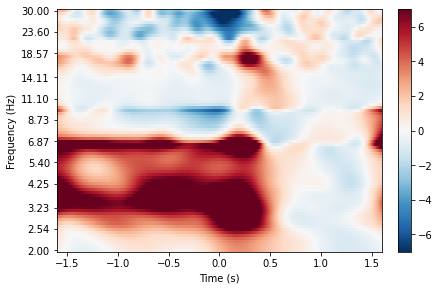

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


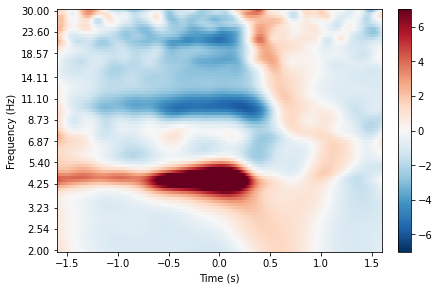

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


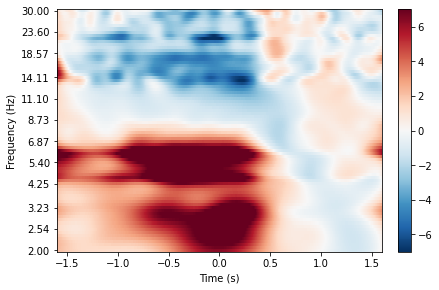

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


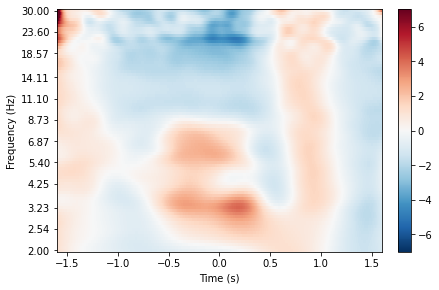

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


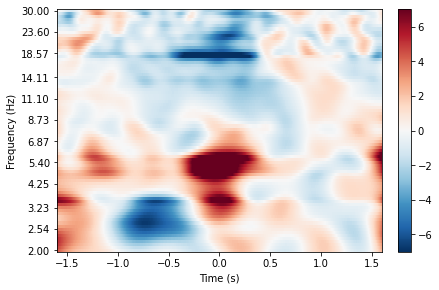

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


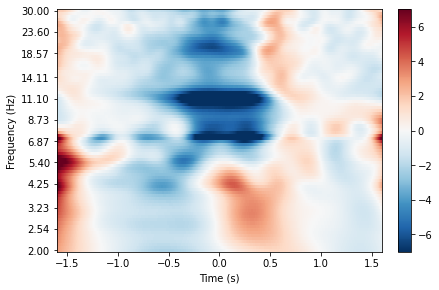

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


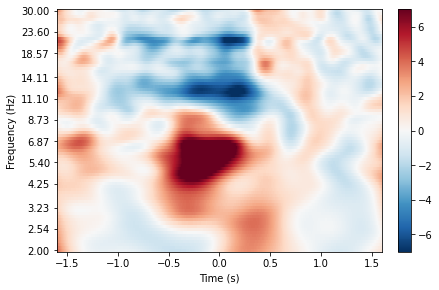

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


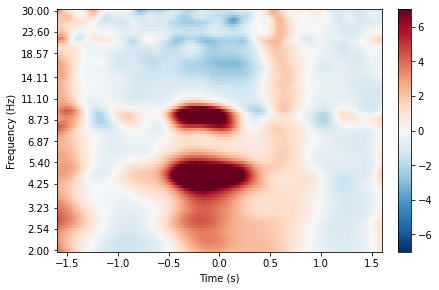

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


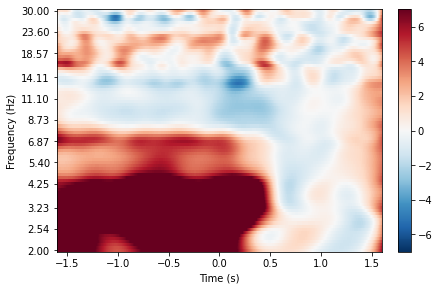

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


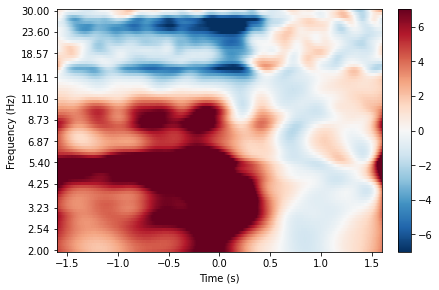

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


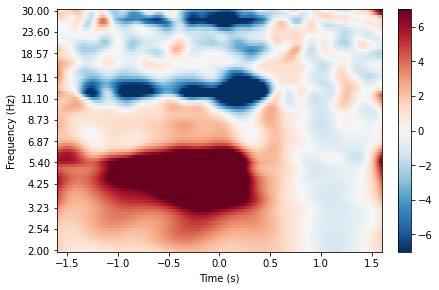

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


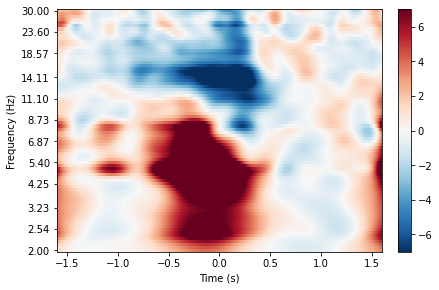

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


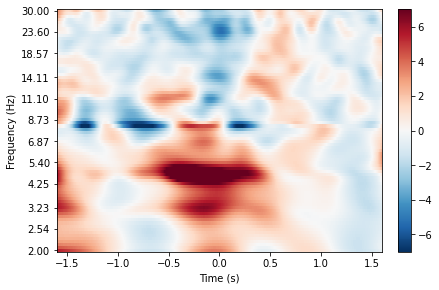

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


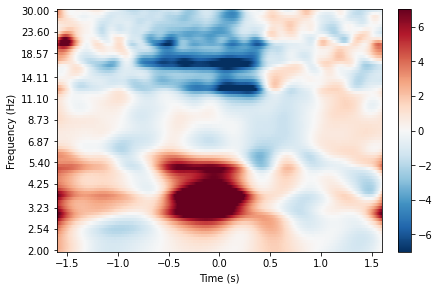

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


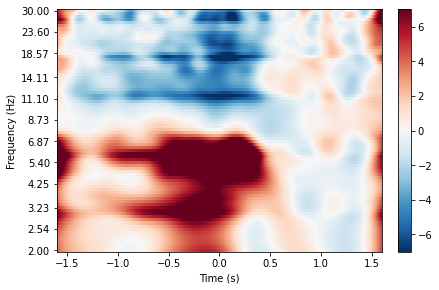

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


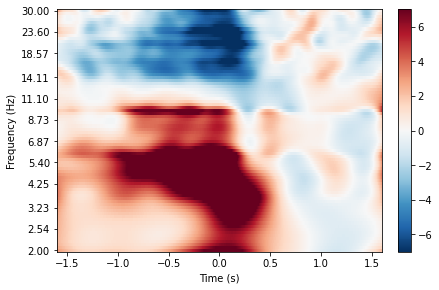

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


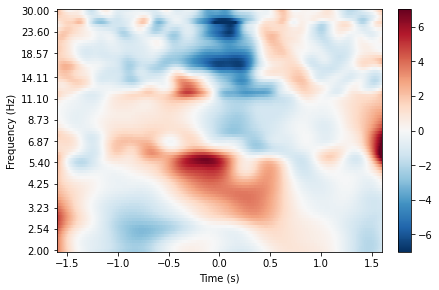

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


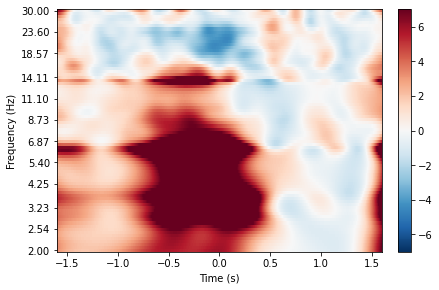

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


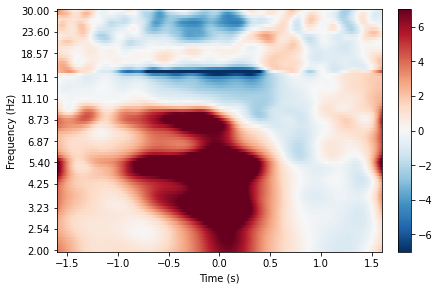

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


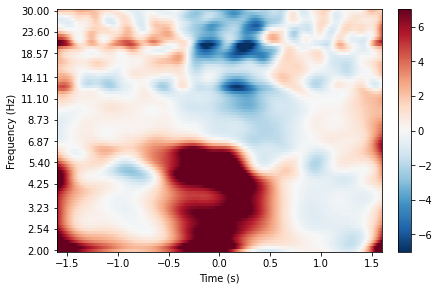

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


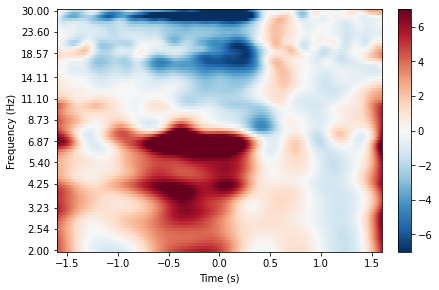

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


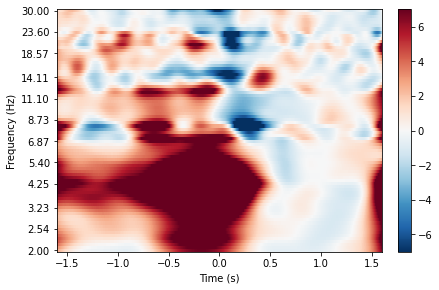

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


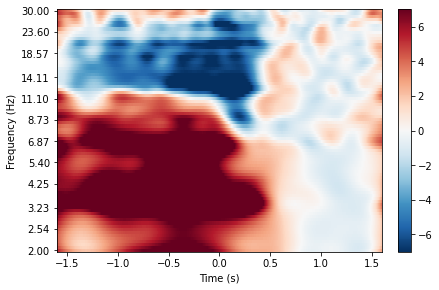

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


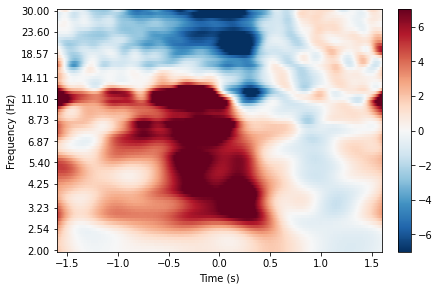

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


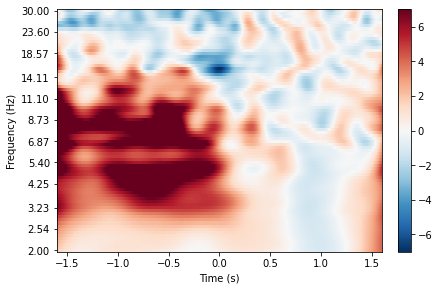

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


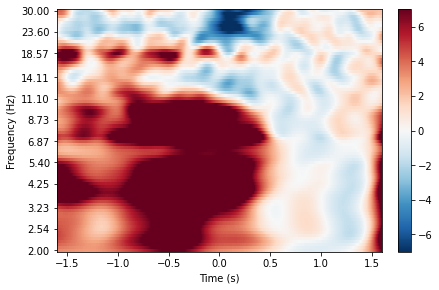

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


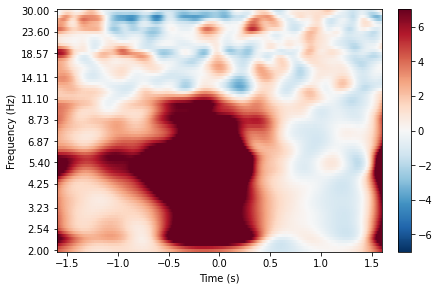

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


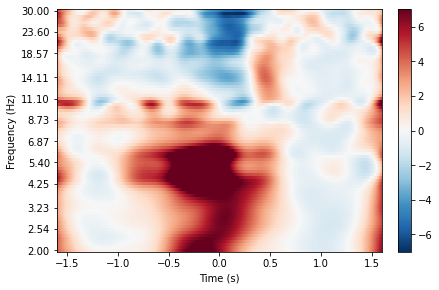

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


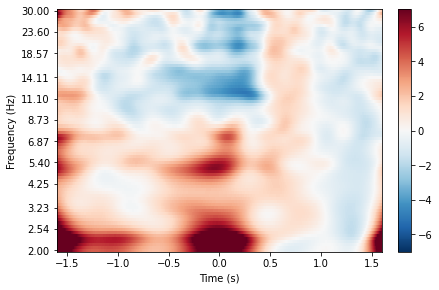

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


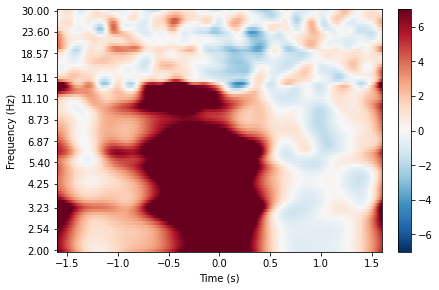

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


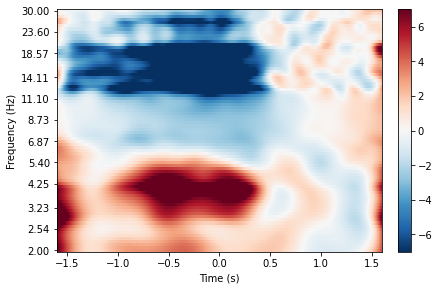

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


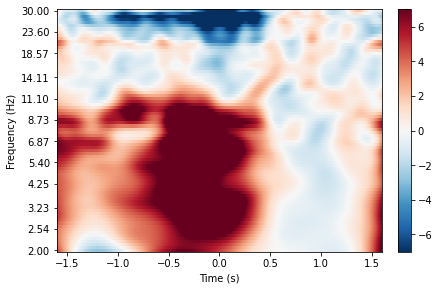

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


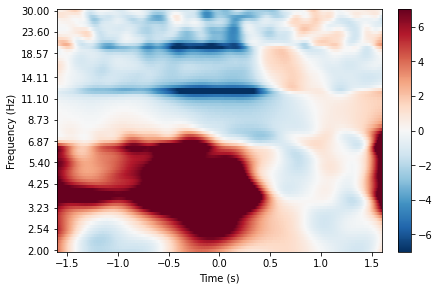

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_19056\4009275425.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


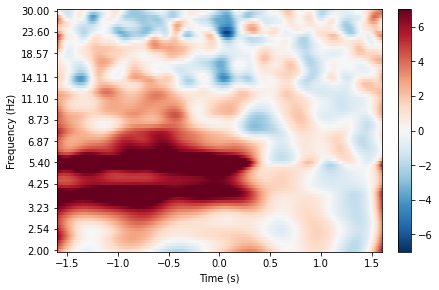

In [3]:
vmin=-7; vmax=7

for part in all_evokeds:
    part.copy().average().plot(vmin=vmin ,vmax=vmax)

In [3]:

all_evokeds_clean = np.delete(all_evokeds,np.where(np.array(participant_n)=="Bad_part"))

c:\Program Files\Anaconda3\envs\eeg\lib\site-packages\numpy\lib\function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [4]:
Yes = mne.grand_average([part["yes"].copy().average()  for part in all_evokeds_clean ])
No = mne.grand_average([part["no"].copy().average() for part in all_evokeds_clean ])
dif_yes_no = No.copy()
dif_yes_no._data -= Yes._data

Identifying common channels ...
Identifying common channels ...


In [69]:
os.chdir('C:/Users/mfbpe/Desktop/DATA/2023_Social_Influence/results')
mask = np.load("mask.npy")

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_4176\79243350.py:3: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Yes.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


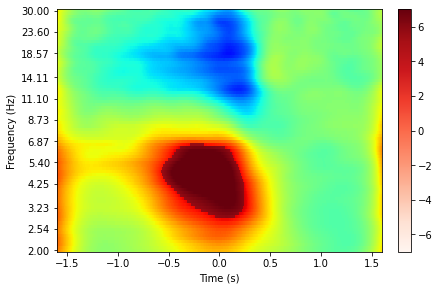

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_4176\79243350.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(No.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


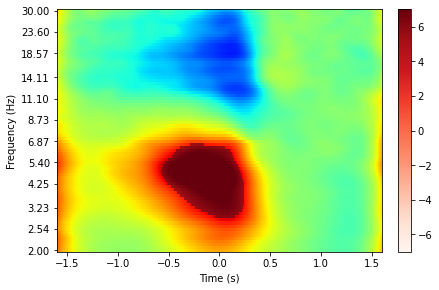

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_4176\79243350.py:5: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(dif_yes_no.plot(vmin=vmin_dif ,vmax=vmax_dif,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


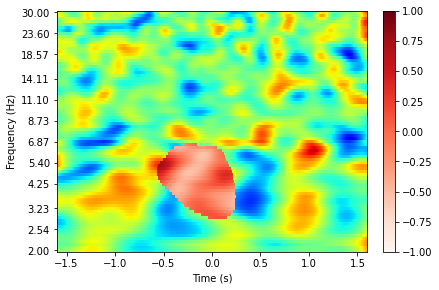

[<Figure size 432x288 with 2 Axes>]


In [6]:

vmin=-7; vmax=7
vmin_dif=-1; vmax_dif=1
print(Yes.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(No.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(dif_yes_no.plot(vmin=vmin_dif ,vmax=vmax_dif,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))

In [7]:

Yes_Belgium = mne.grand_average([part["yes"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Belgium" ])
No_Belgium = mne.grand_average([part["no"].copy().average() for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Belgium" ])
Yes_Cambodia = mne.grand_average([part["yes"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Cambodia" ])
No_Cambodia = mne.grand_average([part["no"].copy().average() for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Cambodia" ])
Yes_Rwanda = mne.grand_average([part["yes"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Rwanda" ])
No_Rwanda = mne.grand_average([part["no"].copy().average() for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Rwanda" ])

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


In [8]:
dif_belgium = No_Belgium.copy()
dif_belgium._data -= Yes_Belgium._data
dif_Cambodia = No_Cambodia.copy()
dif_Cambodia._data -= Yes_Cambodia._data
dif_Rwanda = No_Rwanda.copy()
dif_Rwanda._data -= Yes_Rwanda._data

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_4176\425065723.py:3: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Yes_Belgium.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


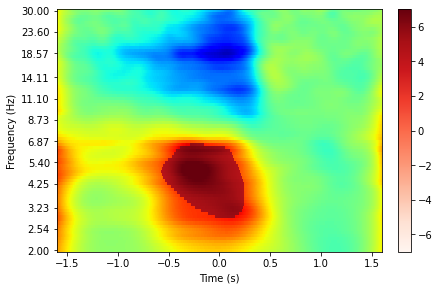

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_4176\425065723.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(No_Belgium.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


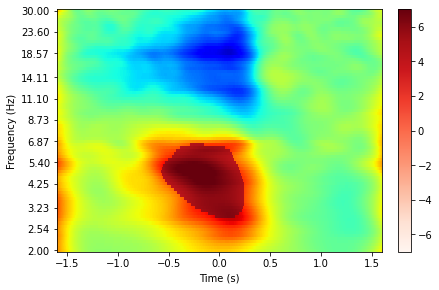

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_4176\425065723.py:5: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(dif_belgium.plot(vmin=vmin_dif ,vmax=vmax_dif,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


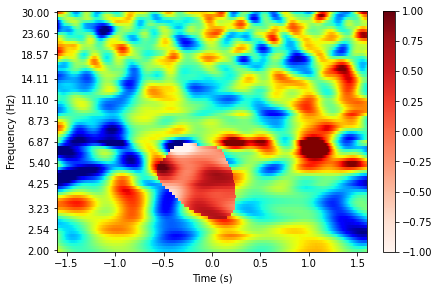

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_4176\425065723.py:6: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Yes_Cambodia.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


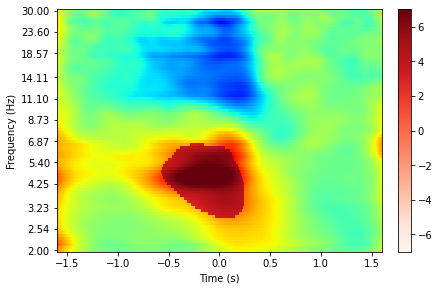

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_4176\425065723.py:7: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(No_Cambodia.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


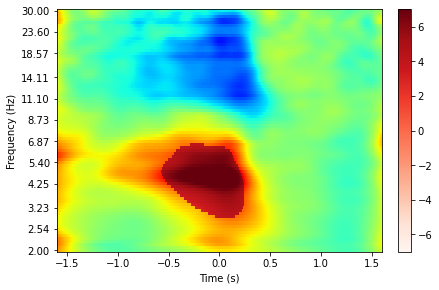

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_4176\425065723.py:8: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(dif_Cambodia.plot(vmin=vmin_dif ,vmax=vmax_dif,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


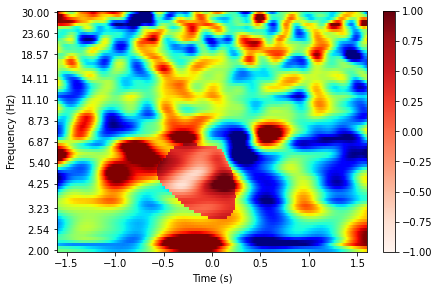

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_4176\425065723.py:9: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Yes_Rwanda.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


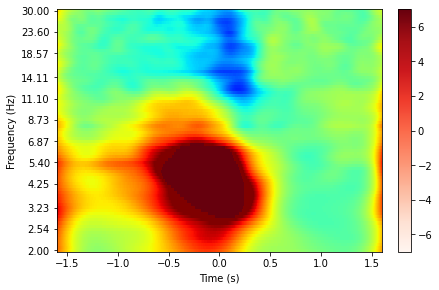

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_4176\425065723.py:10: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(No_Rwanda.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


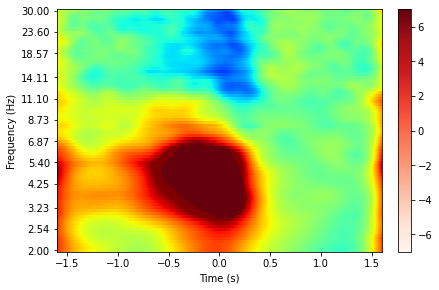

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_4176\425065723.py:11: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(dif_Rwanda.plot(vmin=vmin_dif ,vmax=vmax_dif,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


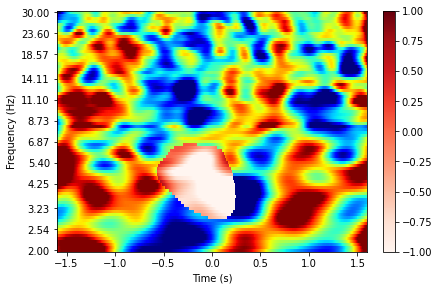

[<Figure size 432x288 with 2 Axes>]


In [9]:

vmin=-7; vmax=7
vmin_dif=-1; vmax_dif=1
print(Yes_Belgium.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(No_Belgium.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(dif_belgium.plot(vmin=vmin_dif ,vmax=vmax_dif,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(Yes_Cambodia.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(No_Cambodia.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(dif_Cambodia.plot(vmin=vmin_dif ,vmax=vmax_dif,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(Yes_Rwanda.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(No_Rwanda.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(dif_Rwanda.plot(vmin=vmin_dif ,vmax=vmax_dif,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))

In [66]:
%%capture       
Auth_no_Belgium = mne.grand_average([part['authority']["no"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Belgium" ])
Group_no_Belgium = mne.grand_average([part['group']["no"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Belgium" ])
Indiv_no_Belgium = mne.grand_average([part['indiv']["no"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Belgium" ]) 
 
Auth_no_Cambodia = mne.grand_average([part['authority']["no"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Cambodia" ])
Group_no_Cambodia = mne.grand_average([part['group']["no"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Cambodia" ])
Indiv_no_Cambodia = mne.grand_average([part['indiv']["no"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Cambodia" ])

Auth_no_Rwanda = mne.grand_average([part['authority']["no"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Rwanda" ])
Group_no_Rwanda = mne.grand_average([part['group']["no"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Rwanda" ])
Indiv_no_Rwanda = mne.grand_average([part['indiv']["no"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Rwanda" ])


No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\2853846087.py:3: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Indiv_no_Belgium.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


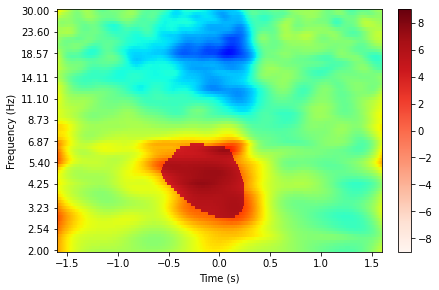

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\2853846087.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Group_no_Belgium.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


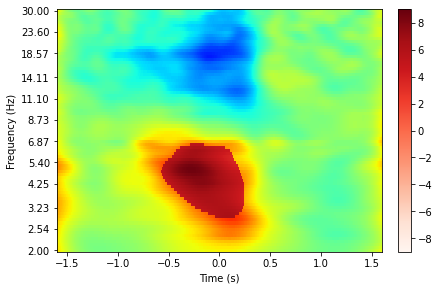

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\2853846087.py:5: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Auth_no_Belgium.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


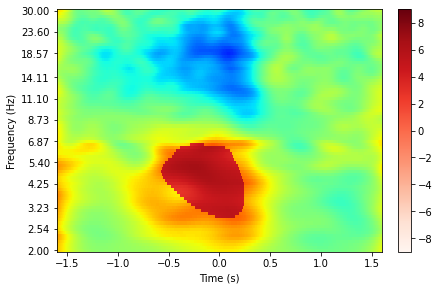

[<Figure size 432x288 with 2 Axes>]


In [79]:
%matplotlib inline
vmin=-7; vmax=7
print(Indiv_no_Belgium.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(Group_no_Belgium.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(Auth_no_Belgium.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\405267154.py:3: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Indiv_no_Cambodia.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


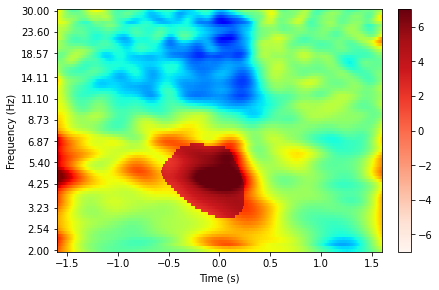

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\405267154.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Group_no_Cambodia.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


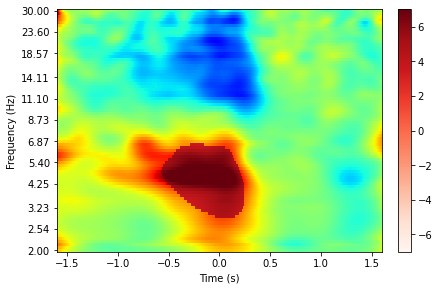

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\405267154.py:5: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Auth_no_Cambodia.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


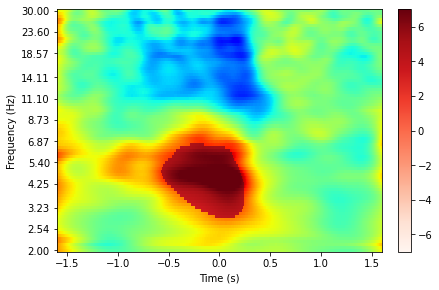

[<Figure size 432x288 with 2 Axes>]


In [68]:
%matplotlib inline
vmin=-7; vmax=7

print(Indiv_no_Cambodia.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(Group_no_Cambodia.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(Auth_no_Cambodia.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\3650562406.py:3: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Indiv_no_Rwanda.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


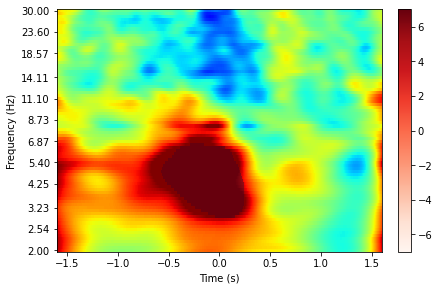

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\3650562406.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Group_no_Rwanda.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


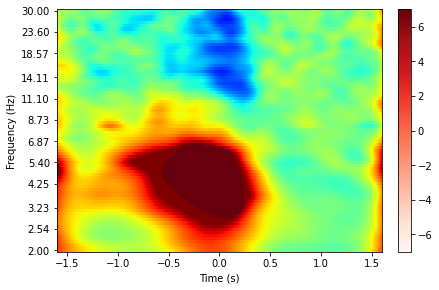

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\3650562406.py:5: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Auth_no_Rwanda.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


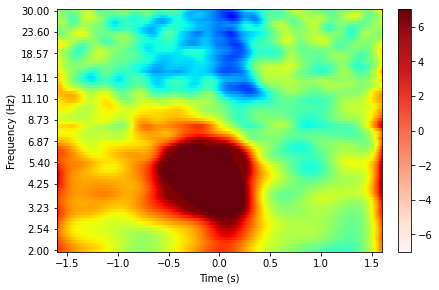

[<Figure size 432x288 with 2 Axes>]


In [82]:
%matplotlib inline
vmin=-7; vmax=7

print(Indiv_no_Rwanda.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(Group_no_Rwanda.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(Auth_no_Rwanda.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))

In [84]:

%%capture       
Auth_yes_Belgium = mne.grand_average([part['authority']["yes"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Belgium" ])
Group_yes_Belgium = mne.grand_average([part['group']["yes"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Belgium" ])
Indiv_yes_Belgium = mne.grand_average([part['indiv']["yes"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Belgium" ]) 
 
Auth_yes_Cambodia = mne.grand_average([part['authority']["yes"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Cambodia" ])
Group_yes_Cambodia = mne.grand_average([part['group']["yes"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Cambodia" ])
Indiv_yes_Cambodia = mne.grand_average([part['indiv']["yes"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Cambodia" ])

Auth_yes_Rwanda = mne.grand_average([part['authority']["yes"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Rwanda" ])
Group_yes_Rwanda = mne.grand_average([part['group']["yes"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Rwanda" ])
Indiv_yes_Rwanda = mne.grand_average([part['indiv']["yes"].copy().average()  for part_i ,part in enumerate(all_evokeds_clean) if participant_n[part_i]=="Rwanda" ])

No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\1232253954.py:3: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Indiv_yes_Belgium.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


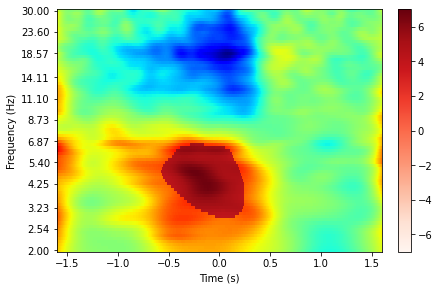

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\1232253954.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Group_yes_Belgium.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


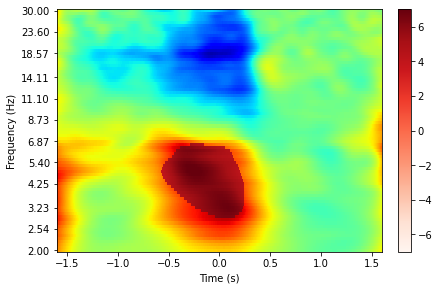

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\1232253954.py:5: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Auth_yes_Belgium.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


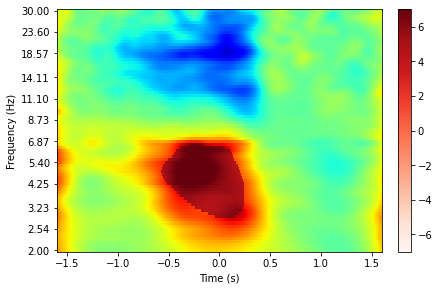

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\1232253954.py:7: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Indiv_yes_Cambodia.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


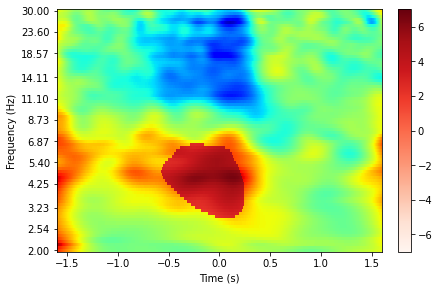

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\1232253954.py:8: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Group_yes_Cambodia.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


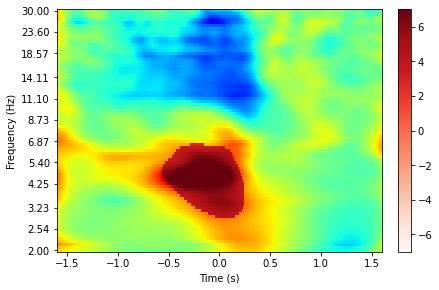

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\1232253954.py:9: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Auth_yes_Cambodia.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


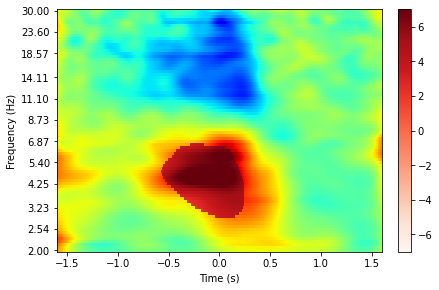

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\1232253954.py:11: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Indiv_yes_Rwanda.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


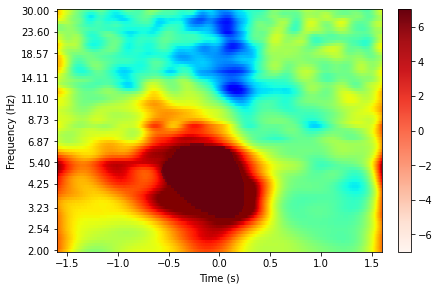

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\1232253954.py:12: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Group_yes_Rwanda.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


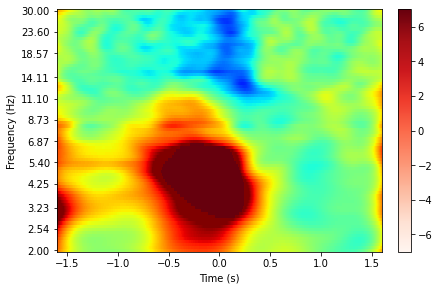

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_11028\1232253954.py:13: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Auth_yes_Rwanda.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


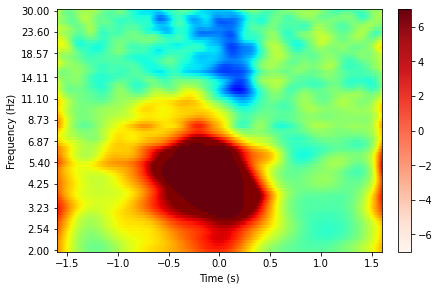

[<Figure size 432x288 with 2 Axes>]


In [85]:
%matplotlib inline
vmin=-7; vmax=7
print(Indiv_yes_Belgium.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(Group_yes_Belgium.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(Auth_yes_Belgium.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))

print(Indiv_yes_Cambodia.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(Group_yes_Cambodia.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(Auth_yes_Cambodia.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))

print(Indiv_yes_Rwanda.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(Group_yes_Rwanda.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(Auth_yes_Rwanda.plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))

In [188]:
%%capture
forced = mne.grand_average([part['forced'].copy().average()  for part in all_evokeds ])
free = mne.grand_average([part['free'].copy().average() for part in all_evokeds ])


In [189]:
gr_forced_free = free.copy()
gr_forced_free.data -= forced.data

In [ ]:
%matplotlib inline

vmin=-2; vmax=4
vmin_dif=-.5; vmax_dif=1
print(forced.crop(-1.5,1.5).plot(vmin=vmin ,vmax=vmax))
print(free.crop(-1.5,1.5).plot(vmin=vmin ,vmax=vmax))
print(gr_forced_free.crop(-1.5,1.5).plot(vmin=vmin_dif ,vmax=vmax_dif))

print(forced.crop(-1.5,1.5).plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(free.crop(-1.5,1.5).plot(vmin=vmin ,vmax=vmax, cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))
print(gr_forced_free.crop(-1.5,1.5).plot(vmin=vmin_dif ,vmax=vmax_dif,cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


In [266]:
os.chdir('C:/Users/mfbpe/Desktop/DATA/2023_Social_Influence/results')
# Create the file "data_SIV2_lmer_tfr.csv" in write mode
datafile = open("SIV2_Cambodia_eeg_lmer_005sign_base500ms_1500ms_type_trial.csv", "w", newline="")

# Create a CSV writer object that writes data to the opened file
writer = csv.writer(datafile, delimiter=";")

# Write a row of column names to the CSV file
writer.writerow([
    "Participant",
    "Trial",
    "Outlier",
    "RT", 
    "Type_trial",
    "Forced_free",
    "Influence",
    "answer",
    "FMtheta"
])

78

In [267]:
# Import the required libraries
import os, mne, csv
import numpy as np
import pandas as pd 
from mne.channels import make_standard_montage
from glob import glob
from scipy import stats
from scipy.stats import iqr, median_abs_deviation as mad
from mne.time_frequency import tfr_morlet

#set directory pathway
os.chdir('C:/Users/mfbpe/Desktop/DATA/2023_Social_Influence/derivatives_with_tfr')


data_files = glob('*_raw.fif')


In [ ]:
%%capture

# Define empty lists to store participant information and drop statistics
participant = {}
drop_stats = []

# Loop over the data files

for part_i,part in enumerate(data_files):
    
    n_part = part.split("sub-")[1].split("_")[0]
    if n_part != '740':
        raw = mne.io.read_raw_fif(part, preload=True)

        if part_i == 0 :
            sphere = mne.make_sphere_model('auto', 'auto', raw.info)
            src = mne.setup_volume_source_space(sphere=sphere)
            forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)
        raw.set_eeg_reference('REST', forward=forward)


        event_dict_vizualization = {'vizualisation/forced/authority/yes':1,'vizualisation/forced/authority/no':2,'vizualisation/forced/group/yes':3,'vizualisation/forced/group/no':4,
        'vizualisation/forced/indiv/yes':5,'vizualisation/forced/indiv/no':6,'vizualisation/free/authority-yes/group-yes':7,'vizualisation/free/authority-yes/group-no':8,'vizualisation/free/authority-no/group-yes':11,
        'vizualisation/free/authority-yes/indiv-yes':9,'vizualisation/free/authority-yes/indiv-no':10, 'vizualisation/free/authority-no/group-no':12,'vizualisation/free/authority-no/indiv-yes':13, 'vizualisation/free/authority-no/indiv-no':14,
        'vizualisation/free/group-yes/indiv-yes':15, 'vizualisation/free/group-yes/indiv-no':16,'vizualisation/free/group-no/indiv-yes':17, 'vizualisation/free/group-no/indiv-no':18}
        event_dict_selection = {'selection/forced/authority/yes':19,'selection/forced/authority/no':20,'selection/forced/group/yes':21,'selection/forced/group/no':22,'selection/forced/indiv/yes':23,'selection/forced/indiv/no':24,
        'selection/free/authority/yes':25,'selection/free/authority/no':26,'selection/free/group/yes':27,'selection/free/group/no':28,'selection/free/indiv/yes':29,'selection/free/indiv/no':30}

        if n_part == '170': # no selection indiv yes free
            event_dict_selection = {'selection/forced/authority/yes':19,'selection/forced/authority/no':20,'selection/forced/group/yes':21,'selection/forced/group/no':22,'selection/forced/indiv/yes':23,'selection/forced/indiv/no':24,
                'selection/free/authority/yes':25,'selection/free/authority/no':26,'selection/free/group/yes':27,'selection/free/group/no':28,'selection/free/indiv/no':30}
        if n_part == '936': # no selection indiv no free
            event_dict_selection = {'selection/forced/authority/yes':19,'selection/forced/authority/no':20,'selection/forced/group/yes':21,'selection/forced/group/no':22,'selection/forced/indiv/yes':23,'selection/forced/indiv/no':24,
                    'selection/free/authority/yes':25,'selection/free/authority/no':26,'selection/free/group/yes':27,'selection/free/group/no':28,'selection/free/indiv/yes':29}
        event_dict = event_dict_vizualization | event_dict_selection
        events,event_dict = mne.events_from_annotations(raw, event_dict)

        epochs_visualization =  mne.Epochs(raw, events, baseline=None, event_id=event_dict_vizualization,
                            picks=['Fz', 'Cz', 'FC1', 'FC2'], tmin=-.1, tmax=.1, reject_by_annotation=False,
                            preload=True, detrend=None, event_repeated='drop', on_missing='ignore')

        # Create epochs from the raw data based on the defined events and event dictionary
        epochs_selection = mne.Epochs(raw, events, baseline=None, event_id=event_dict_selection,
                            picks=['Fz', 'Cz', 'FC1', 'FC2'], tmin=-.1, tmax=.1, reject_by_annotation=False,
                            preload=True, detrend=None, event_repeated='drop', on_missing='ignore')

        if n_part in ['155', '184']:
            epochs_visualization.events = np.concatenate([[[-111111,None,None]], epochs_visualization.events])
            RT = [round((epochs_selection.events[x,0]-epochs_visualization.events[x,0])/512,2) for x in range(len(epochs_visualization.events))]
            RT[0] = None
        elif n_part == "168":
            epochs_visualization.events = np.array(epochs_visualization.events, dtype=object)
            epochs_visualization.events = np.insert(epochs_visualization.events, 439, [-100000000,None,None], 0)
            RT =  [round((epochs_selection.events[x,0]-epochs_visualization.events[x,0])/512,2) for x in range(len(epochs_visualization.events))]
            RT[439] = None
        elif n_part =="936":
            mne.epochs.equalize_epoch_counts([epochs_selection,epochs_visualization])
            epochs_visualization.events = np.concatenate([[[-111111,None,None]], epochs_visualization.events])
            RT = [round((epochs_selection.events[x,0]-epochs_visualization.events[x,0])/512,2) for x in range(len(epochs_selection.events))]
            RT[0] = None
        elif n_part == "164":
            epochs_visualization.events = np.array(epochs_visualization.events, dtype=object)
            epochs_visualization.events = np.insert(epochs_visualization.events, 14, [-100000000,None,None], 0)
            RT =  [round((epochs_selection.events[x,0]-epochs_visualization.events[x,0])/512,2) for x in range(len(epochs_visualization.events))]
            RT[14] = None
        else:    
            RT = [round((epochs_selection.events[x,0]-epochs_visualization.events[x,0])/512,2) for x in range(len(epochs_visualization.events))]
        
        # Create epochs from the raw data based on the defined events and event dictionary
        epochs_selection = mne.Epochs(raw, events, baseline=None, event_id=event_dict_selection,
                            picks=['Fz', 'Cz', 'FC1', 'FC2'], tmin=-2.5, tmax=2.5, reject_by_annotation=False,
                            preload=True, detrend=None, event_repeated='drop', on_missing='ignore')
        
        # Combine channels of the epochs
        event_id = epochs_selection.event_id
        epochs_selection = mne.channels.combine_channels(epochs_selection, dict(Avg=list(range(len(epochs_selection.info['chs'])))))
        epochs_selection.event_id = event_id

        # Apply baseline correction to the epochs data
        epochs_selection.apply_baseline((1,1.5))


        # # Drop trials based on criteria (mean, peak, slope) and obtain drop statistics
        epochs_clean, _, _, _, list_ti, _ = drop_trials(epochs_selection, do_mean=1, do_peak=1, do_slope=0,
                                                    T1=-1.5, T2=1.5, chs=list(range(len(epochs_selection.info['chs']))))




        freqs = np.logspace(np.log10(2), np.log10(30), num=80)  # Frequency range for analysis
        n_cycles = np.logspace(np.log10(4), np.log10(14), 80)  # Number of cycles per frequency
                
        power = tfr_morlet(epochs_clean, freqs=freqs, n_cycles=n_cycles, use_fft=True, average=False,
                        return_itc=False, n_jobs=-1)

        chs=0
        imin_baseline = np.where(power.times<=.5)[0][-1]
        imax_baseline = np.where(power.times<=1.5)[0][-1]
        imin = np.where(power.times<=-1.5)[0][-1]
        imax = np.where(power.times<=1.5)[0][-1]
        for n_trial in range(len(power)):
            data= power._data[n_trial,...]
            mean = np.mean(data[...,imin:imax],axis=-1,keepdims=True)
            std = np.std(data[...,imin:imax],axis=-1,keepdims=True)
            data-=mean
            data /= std


        power_avg = power.average()
        mean_avg = np.mean(power_avg._data[...,imin_baseline:imax_baseline],axis=-1,keepdims=True)
        std_avg = np.std(power_avg._data[...,imin_baseline:imax_baseline],axis=-1,keepdims=True)


        power = tfr_morlet(epochs_selection, freqs=freqs, n_cycles=n_cycles, use_fft=True, average=False,
                        return_itc=False, n_jobs=-1)
        power.crop(-1.6,1.6)


        chs=0
        imin_baseline = np.where(power.times<=.5)[0][-1]
        imax_baseline = np.where(power.times<=1.5)[0][-1]
        imin = np.where(power.times<=-1.5)[0][-1]
        imax = np.where(power.times<=1.5)[0][-1]
        for n_trial in range(len(power)):
            data= power._data[n_trial,...]
            mean = np.mean(data[...,imin:imax],axis=-1,keepdims=True)
            std = np.std(data[...,imin:imax],axis=-1,keepdims=True)
            data-=mean
            data /= std
        list_trigger = [list(event_dict_selection.keys())[list(event_dict_selection.values()).index(power.events[x,2])].split("/") for x in range(len(power))]
        for n_trial in range(len(power)):
            data= power._data[n_trial,...]
            data-=mean_avg
            data /= std_avg
            FMtheta = np.mean(data[mask])

            writer.writerow([n_part,n_trial+1, list_ti[n_trial], RT[n_trial], epochs_visualization.events[n_trial,2],list_trigger[n_trial][1], list_trigger[n_trial][2], list_trigger[n_trial][3], round(FMtheta, 3)])
            datafile.flush()

    # except :
    #     participant[part] = [part_i, "Trouble"]
datafile.close()